In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plot_day_schedule import plot_day_schedule
from pandasql import sqldf
from copy import deepcopy

In [2]:
surgeries = pd.read_csv("surgeries.csv", index_col=0, parse_dates=['start', 'end'])
surgeries.head(5)

,start,end
0,2023-04-25 07:00:00,2023-04-25 07:15:00
1,2023-04-25 07:00:00,2023-04-25 07:30:00
2,2023-04-25 07:00:00,2023-04-25 07:30:00
3,2023-04-25 07:00:00,2023-04-25 07:30:00
4,2023-04-25 07:00:00,2023-04-25 07:45:00


An inspection of the data and also by specification of the assignment, times are at 15 min ticks.<br>
So we will normalize to 15 min tick marks to make it easier to work.

In [3]:
DAY_START = surgeries['start'].min()
TIME_TICK_WIDTH = int(60*15) # All time units will be according to this
MAX_TIME = int((surgeries['end'].max() - DAY_START).total_seconds()/TIME_TICK_WIDTH)

MIN_ANES_TIME = int(5*60/15)
MAX_ANES_TIME = int(12*60/15)
OVERTIME_DUR = int(9*60/15)

NUM_ROOMS = 20
NUM_SURGERIES = len(surgeries)

In [4]:
surgeries['start_tick'] = (surgeries['start'] - DAY_START).dt.total_seconds()//TIME_TICK_WIDTH
surgeries['end_tick'] = (surgeries['end'] - DAY_START).dt.total_seconds()//TIME_TICK_WIDTH
surgeries['duration'] = surgeries['end_tick'] - surgeries['start_tick']

Check that we don't have any surgeries that will lead to an infeasible solution.

In [5]:
print(f"Total surgeries that cannot be assigned an anesthesiologist: {(surgeries['duration'] > MAX_ANES_TIME).sum()}")
print(f"Total surgeries that require an anesthesiologist in overtime: {(surgeries['duration'] > OVERTIME_DUR).sum()}")

Total surgeries that cannot be assigned an anesthesiologist: 0
Total surgeries that require an anesthesiologist in overtime: 0


In the next steps we investigate the number of concurrent surgeries.<br>
The assignment problem is such that if we try to do some large combinatorial optimization - i.e. MIP and others - we will have a huge constraint optimization problem that will be unsolveable.<br>
Now, we look at ways of reducing this complexity.

In [6]:
all_ticks = np.arange(MAX_TIME+1)
calendar = pd.DataFrame(data={'start_tick': all_ticks[:-1], 'end_tick': all_ticks[1:]})
surgery_histogram = sqldf(
    "select c.start_tick, c.end_tick, count(s.start_tick) as freq "
    "from calendar c left join surgeries s "
    "  on c.start_tick >= s.start_tick "
    "  and c.end_tick <= s.end_tick "
    "  group by 1, 2"
)
start_combinations = sqldf(
    "select start_tick, count(start_tick) as freq "
    "from surgeries "
    "  group by 1"
).values[:,1]
print(start_combinations)
print(np.prod(start_combinations[1:]))

[8. 4. 3. 4. 4. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 1. 2. 4. 1. 5. 1. 1. 2. 2.
 2. 1. 3. 2. 1. 2. 3. 1. 3. 1. 3. 1. 4. 2. 2. 1. 5. 1. 1. 2. 1. 3. 4. 3.
 2. 1.]
29353417113600.0


Assuming we already had our anesthesiologists picked out, and the first 8 do not contribute to the variation, then we have 29353417113600 combinations to explore - which is far too many. We must explore for some heuristic estimation.

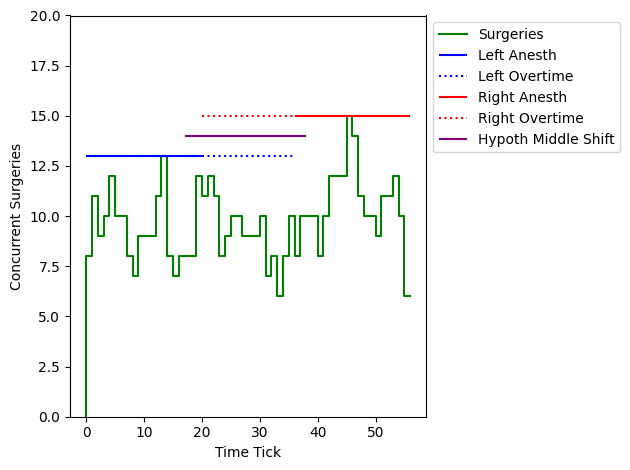

In [7]:
def plot_surgery_histogram(envelope=None):
    plt.step(
        np.append(0, surgery_histogram[['end_tick']]),
        np.append(0, surgery_histogram[['freq']]),
        color='green',
        label='Surgeries'
    )

    max_from_start = surgery_histogram[['freq']][:MIN_ANES_TIME].max().iloc[0]
    max_from_end = surgery_histogram[['freq']][-MIN_ANES_TIME:].max().iloc[0]
    in_between = (max_from_start + max_from_end)/2

    plt.hlines(max_from_start, 0, MIN_ANES_TIME, colors='blue', linestyle='solid', label='Left Anesth')
    plt.hlines(max_from_start, 0, OVERTIME_DUR, colors='blue', linestyle='dotted', label='Left Overtime')
    plt.hlines(max_from_end, MAX_TIME - MIN_ANES_TIME, MAX_TIME, colors='red', linestyle='solid', label='Right Anesth')
    plt.hlines(max_from_end, MAX_TIME - OVERTIME_DUR, MAX_TIME, colors='red', linestyle='dotted', label='Right Overtime')
    plt.hlines(in_between, 17, 18 + MIN_ANES_TIME, colors='purple', linestyle='solid', label='Hypoth Middle Shift')

    if envelope is not None:
        plt.step(
            np.append(0, surgery_histogram[['end_tick']]),
            np.append(0, envelope),
            color='cyan',
            label='Anesth Allocation'
        )

    plt.ylim([0, NUM_ROOMS])
    plt.ylabel("Concurrent Surgeries")
    plt.xlabel("Time Tick")
    plt.legend(bbox_to_anchor=(1., 1.))
    plt.tight_layout()

plot_surgery_histogram()

Let's notice a few things:<br>

1. At all times, we have at least 6 concurrent surgeries running somewhere.<br>
2. Anesthesiologists must be allocated a minimum of at least 5 hours.<br>
3. The solid blue/red lines show us this minimum duration from the first/last surgeries.<br>
4. Additionally, anesthesiologists can work an additional 4 hours without getting overtime - dotted lines.<br>
5. The purple line shows us a proposed middle shift of minimum 5 hours.<br>
6. No anesthesiologists can work the whole day - 56 ticks > 48.<br>

These observations tell us that we should operate 2 general shifts: one from the start and one from the end.<br>
This is the case because of the following reasons:<br>

1. The dotted lines overlap, suggesting that during this time we can retire one anesthesiologist and then bring the next shift as needed.<br>
2. We would only need to consider using a middle shift if we saw that the the concurrent surgeries during this time exceeded either one of the dotted lines - the maximum during the ramp-up/slow-down periods - which it does not.<br>
3. In considering room assignments, we should not move anesthesiologist between rooms since it will cost 15 min per move and it is not needed.<br>
4. The reason for (3) is that we will always have the maximum needed anesthesiologist up to that given point and no more are needed. If the anesthesiologist is available, then so is their room.
5. We can reuse rooms as we retire anesthesiologist.

This suggests that we can find an upper-bound to the histogram of active anesthesiologist, as below.<br>
It means that we do the bare minimum assignment during the ramp-up/slow-down periods, and during the overlap we begin retiring the first shift as soon as possible to replace with the second shift as needed.<br>

In [8]:
freq = surgery_histogram['freq'].values

anesth_alloc_left = np.array([0])
anesth_alloc_right = np.array([0])

for n in range(MIN_ANES_TIME):
    anesth_alloc_left = np.append(anesth_alloc_left, max(anesth_alloc_left[-MIN_ANES_TIME:].max(), freq[n]))
    anesth_alloc_right = np.append(max(anesth_alloc_right[:MIN_ANES_TIME].max(), freq[-n-1]), anesth_alloc_right)

for n in range(MIN_ANES_TIME, OVERTIME_DUR):
    anesth_alloc_left = np.append(
        anesth_alloc_left,
        max(
            freq[n],
            anesth_alloc_left[-1] - (anesth_alloc_left[n-MIN_ANES_TIME+1] - anesth_alloc_left[n-MIN_ANES_TIME])
        )
    )
    anesth_alloc_right = np.append(
        max(
            freq[-n-1],
            anesth_alloc_right[0] - (anesth_alloc_right[MIN_ANES_TIME-n-2] - anesth_alloc_right[MIN_ANES_TIME-n-1])
        ),
        anesth_alloc_right
    )

anesth_alloc = np.maximum(
    np.append(anesth_alloc_left, np.zeros([MIN_ANES_TIME+1])),
    np.append(np.zeros([MIN_ANES_TIME+1]), anesth_alloc_right)
)[1:-1]

print(f"UB solution cost is: {anesth_alloc.sum()}")

UB solution cost is: 681.0


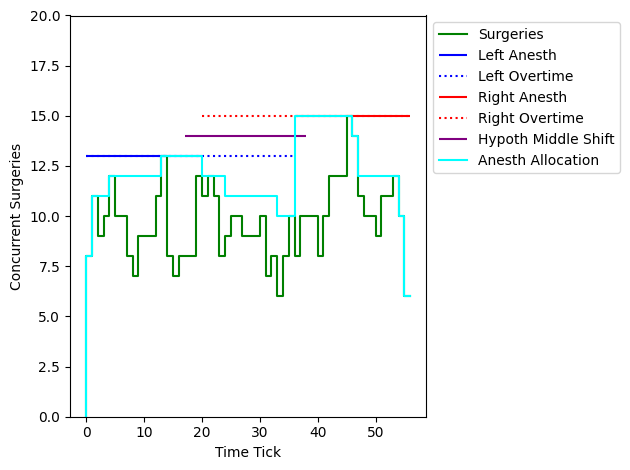

In [9]:
plot_surgery_histogram(anesth_alloc)

The below simulation takes a pre-planned hire/retire route - like the UB we have above - and randomly assigns them valid surgeries.<br>
It operates in two modes:<br>
1. Terminate pre-maturely if the simulation could not hit the plan or it ends with the results.
2. Do not terminate pre-maturely and and try to retire in the next time step.

In [10]:
def simulate(anesth_alloc, early_terminate: bool):
    anesthetists = pd.DataFrame(columns=['start_tick', 'end_tick', 'last_surgery_end', 'room'])

    for curr_tick in range(MAX_TIME):
        # If we are during the first shifts overtime, then begin retiring if available
        while curr_tick > MAX_TIME-OVERTIME_DUR:
            available_anesth = anesthetists[
                (anesthetists['last_surgery_end'] <= curr_tick) *
                ~(anesthetists['end_tick'] <= curr_tick) *
                (anesthetists['start_tick'] <= MAX_TIME-OVERTIME_DUR) *
                (anesthetists['start_tick'] <= curr_tick-MIN_ANES_TIME)
            ]
            if len(available_anesth) == 0:
                break
            
            # Select earliest hired anesthesiologist
            anesthet_id = available_anesth.index[0]
            # Break/Terminate if we cannot retire them, yet
            if curr_tick - anesthetists.loc[anesthet_id, 'start_tick'] < MIN_ANES_TIME:
                if early_terminate:
                    return curr_tick, None, True
                break

            # Retire them, picking an earlier time then current if possible
            anesthetists.loc[anesthet_id, 'end_tick'] = max(
                min(curr_tick, anesthetists.loc[anesthet_id, 'last_surgery_end']),
                anesthetists.loc[anesthet_id, 'start_tick'] + MIN_ANES_TIME
            )

        # If we have more anesthesiologist than pre-planned, then begin retiring if available
        while anesth_alloc[curr_tick] < sum(~(anesthetists['end_tick'] <= curr_tick)):
            available_anesth = anesthetists[
                ~(anesthetists['last_surgery_end'] > curr_tick) *
                ~(anesthetists['end_tick'] <= curr_tick)
            ]
            
            # Select earliest hired anesthesiologist
            anesthet_id = available_anesth.index[0]
            # Break/Terminate if we cannot retire them, yet
            if curr_tick - anesthetists.loc[anesthet_id, 'start_tick'] < MIN_ANES_TIME:
                if early_terminate:
                    return curr_tick, None, True
                break
                
            # Retire them, picking an earlier time then current if possible
            anesthetists.loc[anesthet_id, 'end_tick'] = max(
                min(curr_tick, anesthetists.loc[anesthet_id, 'last_surgery_end']),
                anesthetists.loc[anesthet_id, 'start_tick'] + MIN_ANES_TIME
            )

        # If we do not have enough anesthesiologist, hire more
        while anesth_alloc[curr_tick] > sum(~(anesthetists['end_tick'] <= curr_tick)):
            anesthetists.loc[len(anesthetists)] = {
                'start_tick': curr_tick,
                'end_tick': None,
                'last_surgery_end': None,
                'room': None
            }
            
        # Assign surgeries to available anesthesiologist, randomly
        curr_surgeries = surgeries[surgeries['start_tick'] == curr_tick].sample(frac = 1)
        for idx, surgery in curr_surgeries.iterrows():
            available_anesth = anesthetists[
                ~(anesthetists['last_surgery_end'] > curr_tick) *
                ~(anesthetists['end_tick'] <= curr_tick) * 
                (surgery['end_tick'] - anesthetists['start_tick'] <= OVERTIME_DUR)
            ]
            # Select the last hired anesthesiologist
            anesthet_id = available_anesth.index[-1]
            surgeries.loc[idx,'anesthetist'] = anesthet_id
            anesthetists.loc[anesthet_id, 'last_surgery_end'] = surgery['end_tick']
        
    return curr_tick, anesthetists, False

In [11]:
try_again = True
while try_again:
    tick, anesthetists, try_again = simulate(anesth_alloc, True)
    print(f"No solution found in {tick} ticks", end="\r")

mask = anesthetists['end_tick'].isna()
anesthetists.loc[mask,'end_tick'] = anesthetists[mask]['last_surgery_end']
durations = (anesthetists['end_tick']-anesthetists['start_tick']).values
cost = (durations + 0.5*np.maximum(0, durations-OVERTIME_DUR)).sum()

print(f"                                                 ", end="\r")
print(f"Solution Found")
print(f"Total Cost: {cost}")

Solution Found                                   
Total Cost: 680.0


The solution we found using the UB plan has total cost of 680, which is 1 less than the UB of 681.<br>
This is because in our simulation, we retire the anesthesiologist earlier if possible.<br>
*Notice:* it is possible to run this and end up in a solution that has a total cost of 681, as well.

Let's now try running a few simulations with a more constrained plan - i.e. a lower bound.<br>
The difference here is that the plan assumes that we can always retire anesthesiologist from the first shift at each tick, which is not necessarily true.<br>
But if true, then we cannot do any better.

LB possible cost is: 658.0


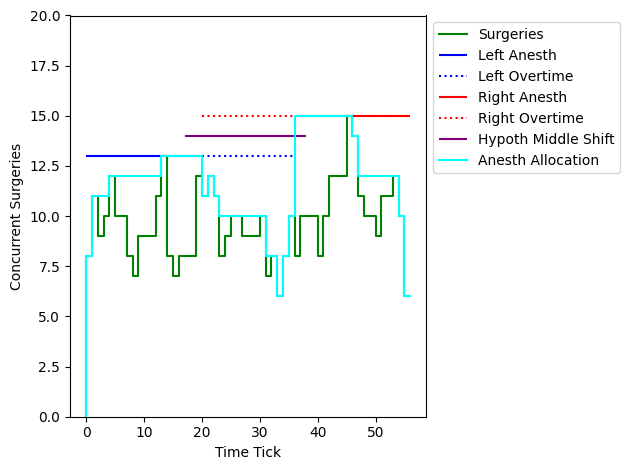

In [12]:
anesth_alloc = np.minimum(
    np.append(anesth_alloc_left, 20*np.ones([MIN_ANES_TIME+1])),
    np.append(20*np.ones([MIN_ANES_TIME+1]), anesth_alloc_right)
)[1:-1]

print(f"LB possible cost is: {anesth_alloc.sum()}")
plot_surgery_histogram(anesth_alloc)

In [13]:
min_cost = 680  # From our UB plan
for _ in range(100):
    tick, anesthetists, try_again = simulate(anesth_alloc, False)

    mask = anesthetists['end_tick'].isna()
    anesthetists.loc[mask,'end_tick'] = anesthetists[mask]['last_surgery_end']

    durations = (anesthetists['end_tick']-anesthetists['start_tick']).values
    cost = (durations + 0.5*np.maximum(0, durations-OVERTIME_DUR)).sum()
    if cost < min_cost:
        min_anesthetists = deepcopy(anesthetists)
        min_surgeries = deepcopy(surgeries)
        min_cost = cost

    print(f"Total Cost of current solution: {cost} | Best Solution: {min_cost}", end="\r")


The best solution found has a total cost of 663, much better than our previous and pretty close to the LB of 658.<br>
Now we only need to assign the rooms and create the schedule - and we only really need 15 rooms.

In [14]:
first_shift = min_anesthetists[min_anesthetists['start_tick'] < MIN_ANES_TIME].sort_values(by='end_tick').index

room_counter = 0
for idx in first_shift:
    min_anesthetists.loc[idx, 'room'] = room_counter
    room_counter += 1

room_counter = 0
for idx in range(max(first_shift)+1, len(min_anesthetists)):
    min_anesthetists.loc[idx, 'room'] = room_counter
    room_counter += 1

min_anesthetists

,start_tick,end_tick,last_surgery_end,room
0,0,20,15.0,0
1,0,23,23.0,5
2,0,29,29.0,8
3,0,20,20.0,1
4,0,29,29.0,9
5,0,21,21.0,2
6,0,25,25.0,6
7,0,29,29.0,10
8,1,21,21.0,3
9,1,22,22.0,4


In [15]:
min_anesthetists['anesthetist'] = min_anesthetists.index

surgery_assigments = sqldf(
    "select s.start as start_time, s.end as end_time, "
    "   \'anesthetist - \' || a.anesthetist as anesthetist_id, \'room - \' || a.room room_id "
    "from min_surgeries s "
    " join min_anesthetists a "
    "   on s.anesthetist = a.anesthetist "
)

surgery_assigments.to_csv("surgery_assigments.csv")

c:\Users\ilana\OneDrive\Documents\PythonProjects\opmed\plot_day_schedule.py:39: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


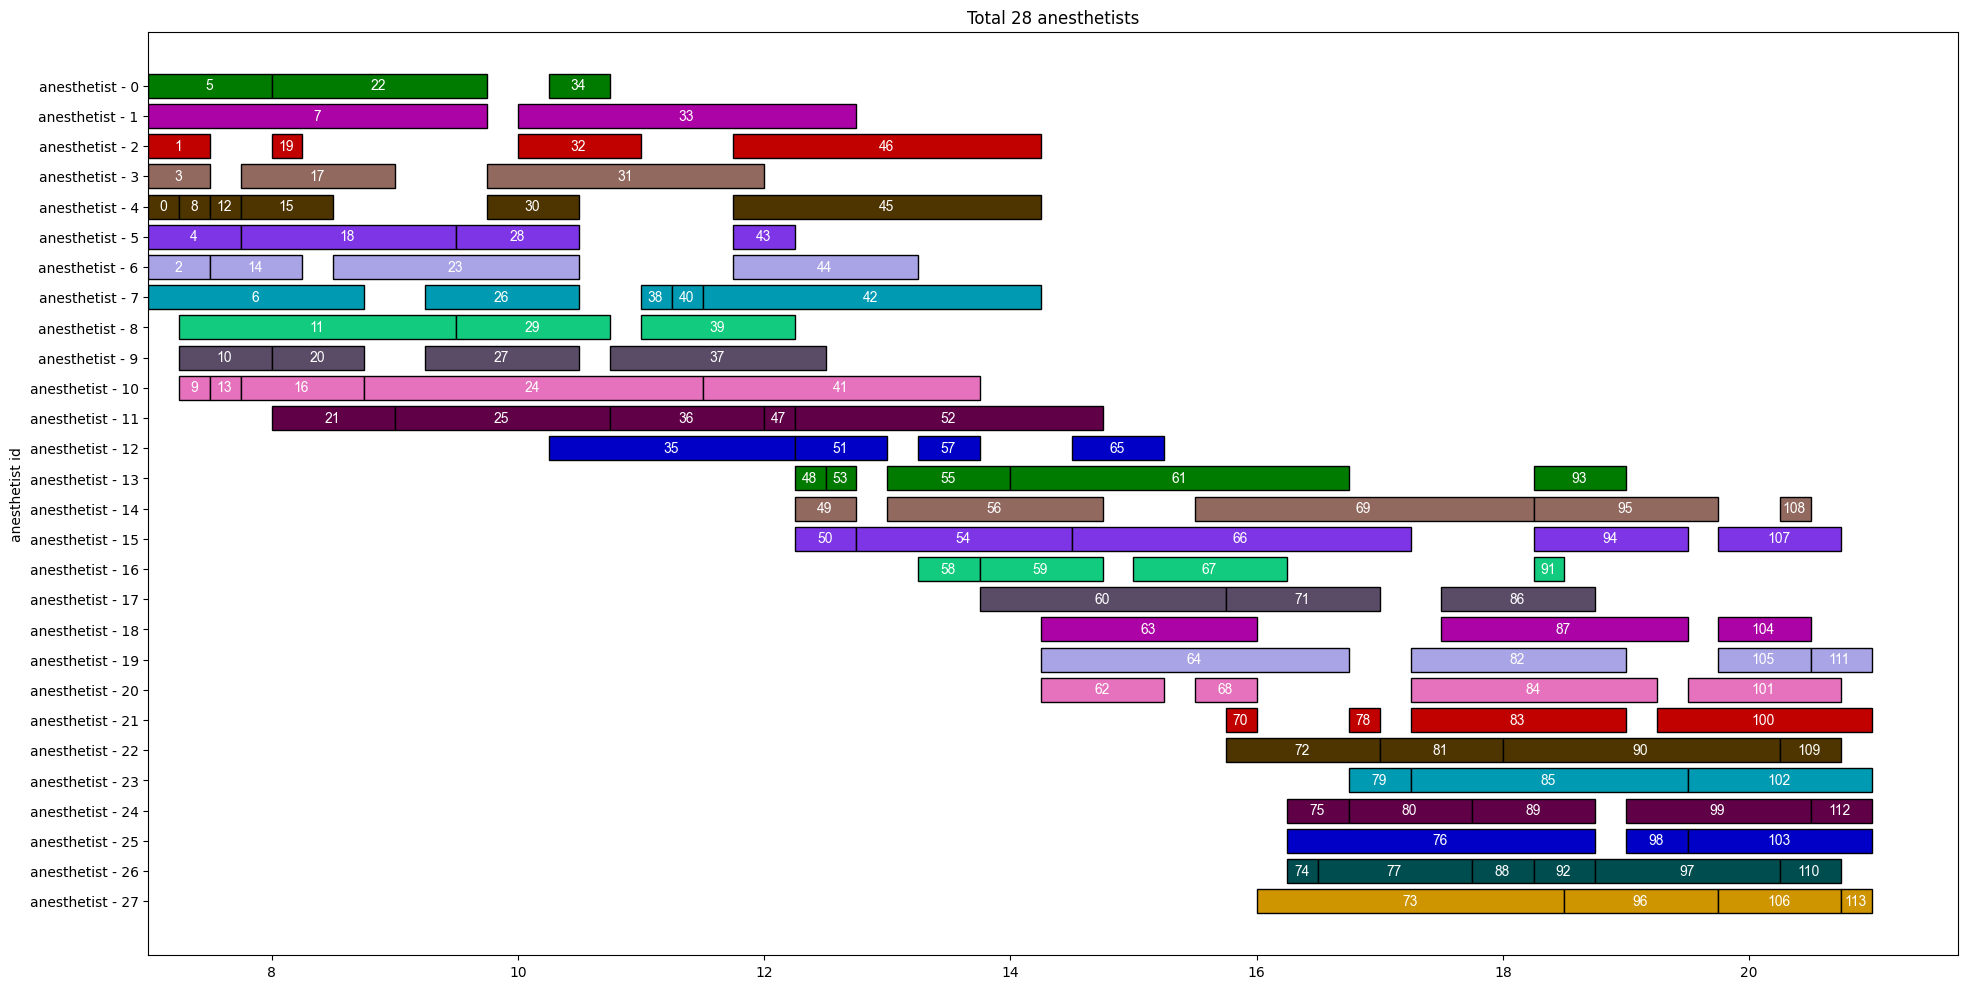

In [16]:
# There is some problem with the date format from sqldf, so I reparsed - also to check the format
surgery_assigments = pd.read_csv("surgery_assigments.csv", index_col=0, parse_dates=['start_time', 'end_time'])
plot_day_schedule(surgery_assigments)